In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import ast
import re 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_csv("DelhiNCR_data_updated.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2981 entries, 0 to 2980
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   res_id                2981 non-null   int64  
 1   name                  2981 non-null   object 
 2   establishment         2981 non-null   object 
 3   address               2981 non-null   object 
 4   city                  2981 non-null   object 
 5   city_id               2981 non-null   int64  
 6   locality              2981 non-null   object 
 7   latitude              2981 non-null   float64
 8   longitude             2981 non-null   float64
 9   zipcode               1134 non-null   object 
 10  country_id            2981 non-null   int64  
 11  locality_verbose      2981 non-null   object 
 12  cuisines              2981 non-null   object 
 13  timings               2981 non-null   object 
 14  average_cost_for_two  2981 non-null   int64  
 15  price_range          

DATA PRE PROCESSING AND CLEANING

In [ ]:
def clean_data(df):
    columns_to_drop = ['zipcode', 'currency', 'opentable_support', 'city_id', 'STATE', 'AREA', 'country_id', 'locality_verbose', 'rating_text', 'timings']
    df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

    df = df[(df['latitude'] >= 28.4) & (df['latitude'] <= 28.88)]
    df = df[(df['longitude'] >= 76.9) & (df['longitude'] <= 77.6)]

    df = df[(df['establishment'].apply(lambda x: len(x) > 2))]  # to check for non-empty lists
    df = df[df['average_cost_for_two'] > 0]

    df['locality'].fillna('Unknown', inplace=True)
    df['cuisines'].fillna('Not specified', inplace=True)
    df.drop_duplicates(inplace=True)
    
    df['city'] = df['city'].str.strip().str.lower()
    df['locality'] = df['locality'].str.strip().str.title()

    df['city'] = df['city'].replace({'delhi': 'Delhi', 'new delhi': 'Delhi'})
    df['cuisines'] = df['cuisines'].str.strip().str.title()

    df = df[(df['latitude'] != 0) & (df['longitude'] != 0)]
    
    df['establishment'] = df['establishment'].apply(lambda x: ''.join(x))
    
    def extract_locality(locality):
        if ',' in locality:
            return locality.split(',')[-1].strip() 
        else:
            return locality  
    df['locality'] = df['locality'].apply(lambda x: extract_locality(x))

    def convert_to_list(establishment):
        try:
            return ', '.join(ast.literal_eval(establishment))
        except:
            return establishment

    df['establishment'] = df['establishment'].apply(convert_to_list)
    df['establishment'].replace('CafÃ©', 'Cafe', inplace=True)
    
    unique_establishments = df['establishment'].unique()
    establishment_mapping = {est: idx for idx, est in enumerate(unique_establishments)}
    df['establishment_mapped'] = df['establishment'].map(establishment_mapping)
    
    unique_locality = df['locality'].unique()
    locality_mapping = {est: idx for idx, est in enumerate(unique_locality)}
    df['locality_mapped'] = df['locality'].map(locality_mapping)
    
    def process_highlight(highlight):
        try:
            return ast.literal_eval(highlight)
        except (ValueError, SyntaxError):
            return highlight.split()

    df['highlights'] = df['highlights'].apply(process_highlight)
    
    min_max_scaler = MinMaxScaler()
    features_to_scale = ['average_cost_for_two', 'votes']
    df[features_to_scale] = min_max_scaler.fit_transform(df[features_to_scale])
    
    print("Data cleaned and extreme outliers removed!")
    return df

cleaned_df = clean_data(df)
cleaned_df.head()


C:\Users\hp\AppData\Local\Temp\ipykernel_7808\735614140.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['locality'].fillna('Unknown', inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_7808\735614140.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

Data cleaned and extreme outliers removed!


,res_id,name,establishment,address,city,locality,latitude,longitude,cuisines,average_cost_for_two,price_range,highlights,aggregate_rating,delivery,takeaway,votes,establishment_mapped,locality_mapped
1,18429148,Pa Pa Ya,Fine Dining,"Dome, Level 4, Select Citywalk, A-3, District ...",Delhi,Saket,28.528391,77.218611,"Asian, Chinese, Thai, Japanese",0.308176,4,"[Credit Card, Debit Card, Lunch, Serves Alcoho...",4.7,-1,-1,0.219239,0,0
2,18418277,Ministry Of Beer,Lounge,"M 44, Outer Circle, Connaught Place, New Delhi",Delhi,Connaught Place,28.633286,77.222787,"Continental, Italian, Asian, Momos",0.182390,3,"[Lunch, Credit Card, Dinner, Cash, Debit Card,...",4.5,-1,-1,0.206291,1,1
3,18625812,Detroit,Bar,"F40, 2nd Floor, Inner Circle, \nConnaught Plac...",Delhi,Connaught Place,28.631357,77.220251,"Bar Food, Mexican, Italian",0.182390,3,"[Lunch, Serves Alcohol, Takeaway Available, De...",4.6,-1,-1,0.089960,2,1
4,18423151,The Darzi Bar & Kitchen,Casual Dining,"H 55, 1st Floor, Outer Circle, Connaught Place...",Delhi,Connaught Place,28.635508,77.219096,"North Indian, Chinese, Continental, Pizza",0.182390,3,"[Lunch, Serves Alcohol, Cash, Credit Card, Din...",4.3,-1,-1,0.217680,3,1
5,18649486,The Drunken Botanist,Bar,"Unit 1B & 1C, Upper Ground Floor-C, Building 1...",gurgaon,Dlf Cyber City,28.493674,77.088334,"Continental, Italian, North Indian, Chinese",0.245283,4,"[Dinner, Cash, Credit Card, Lunch, Serves Alco...",4.4,-1,-1,0.376517,2,2


In [4]:

mlb = MultiLabelBinarizer()
one_hot_encoded_highlights = mlb.fit_transform(cleaned_df['highlights'])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_highlights, columns=mlb.classes_)
one_hot_encoded_vectors = one_hot_encoded_df.values.tolist()
vector_df = pd.DataFrame({'highlight_vector': one_hot_encoded_vectors})

one_hot_encoded_cuisines = mlb.fit_transform(cleaned_df['cuisines'])
one_hot_encoded_cuisine_df = pd.DataFrame(one_hot_encoded_cuisines, columns=mlb.classes_)
one_hot_encoded_cuisine_vector = one_hot_encoded_cuisine_df.values.tolist()
vector_df_for_cuisines = pd.DataFrame({'cuisine_vector': one_hot_encoded_cuisine_vector})

EXPLORATORY DATA ANAYLYSIS 

In [5]:
import folium

map_center = [28.6139, 77.2090]  # Latitude and longitude for Delhi ncr
mymap = folium.Map(location=map_center, zoom_start=11)

def add_markers_to_map(map_obj, df):
    for i, row in df.iterrows():
        lat = row['latitude']
        lon = row['longitude']
        name = row['locality']  
        folium.Marker(location=[lat, lon], popup=name).add_to(map_obj)

add_markers_to_map(mymap, cleaned_df)
mymap


In [6]:
from folium.plugins import HeatMap

center_lat, center_lon = cleaned_df['latitude'].mean(), cleaned_df['longitude'].mean()
base_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)
heat_data = [[row['latitude'], row['longitude']] for index, row in cleaned_df.iterrows()]
HeatMap(heat_data).add_to(base_map)

base_map


DATA ENGINEERING 

In [7]:
#TO FIND AVERAGE RATINGS AND VOTES OF A LOCALITY
locality_analysis = cleaned_df.groupby('locality').agg(
avg_local_rating=('aggregate_rating', 'mean'),
avg_local_votes=('votes', 'mean')
).reset_index()

cleaned_df = pd.merge(cleaned_df, locality_analysis, on='locality', how='left')

In [8]:
# TO FIND DENSITY OF RESTAUTRANTS I AN AREA 
from sklearn.neighbors import BallTree

coordinates = np.radians(cleaned_df[['latitude', 'longitude']].values)
tree = BallTree(coordinates, metric='haversine')
radius = 1 / 6371.0  # FOR FINDING THE COMPETRION DENSITY WITHING 1 KM OF RADIUS
def calculate_competition_density_balltree(lat, lon):
    point = np.radians([[lat, lon]])
    indices = tree.query_radius(point, r=radius)
    return len(indices[0]) - 1  

cleaned_df['competition_density'] = cleaned_df.apply(lambda row: calculate_competition_density_balltree(row['latitude'], row['longitude']), axis=1)
print(cleaned_df[['name', 'competition_density']])

                                    name  competition_density
0                               Pa Pa Ya                   46
1                       Ministry Of Beer                  145
2                                Detroit                  143
3                The Darzi Bar & Kitchen                  137
4                   The Drunken Botanist                   79
...                                  ...                  ...
2634                            Cervesia                   65
2635                           Impromptu                   20
2636  Norenj Wine Dine & Fresh Beer Cafe                   30
2637                      Sixth Empirica                   31
2638                     Lavaash By Saby                   11

[2639 rows x 2 columns]


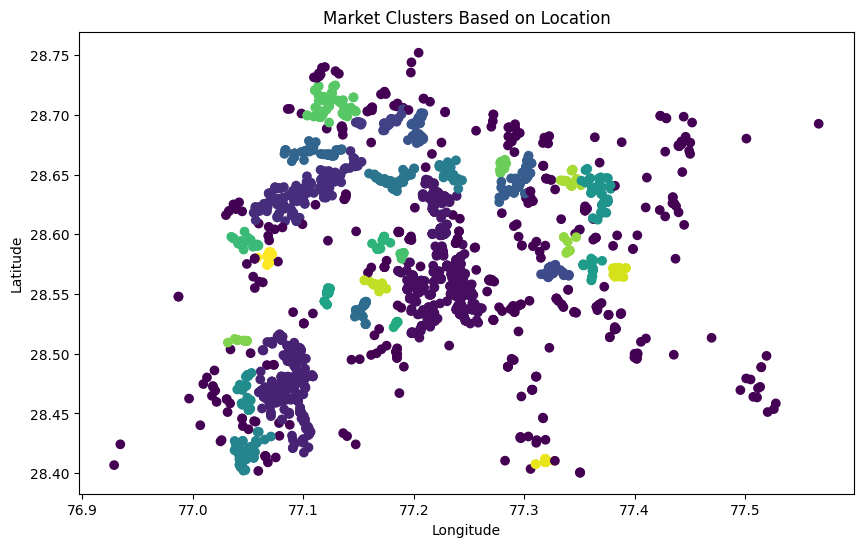

In [9]:
dbscan = DBSCAN(eps = 0.009, min_samples=10)
cleaned_df['market_cluster'] = dbscan.fit_predict(cleaned_df[['latitude', 'longitude']])

plt.figure(figsize=(10, 6))
plt.scatter(cleaned_df['longitude'], cleaned_df['latitude'], c=cleaned_df['market_cluster'], cmap='viridis', marker='o')
plt.title('Market Clusters Based on Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
final_df = pd.concat([cleaned_df, vector_df, vector_df_for_cuisines], axis=1)
# final_df.head()

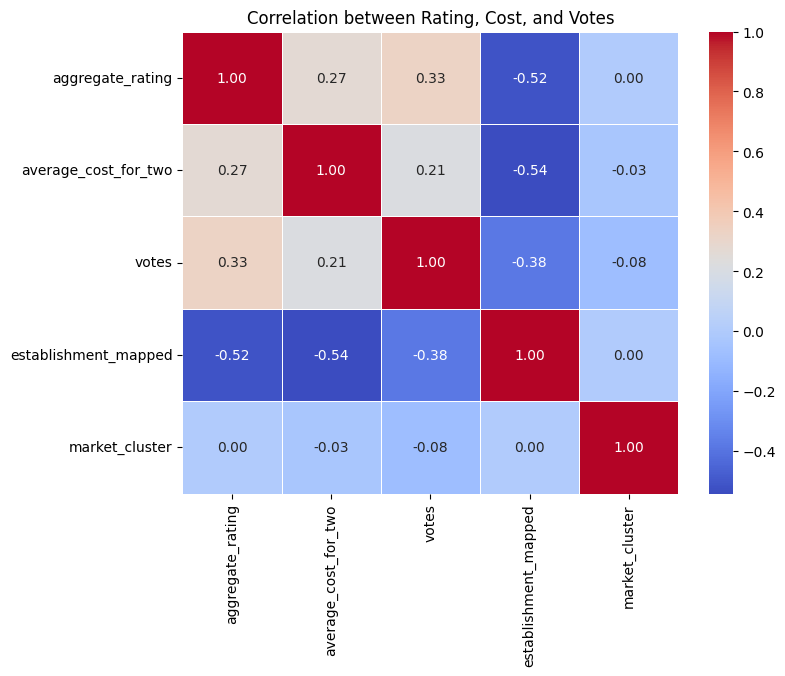

In [11]:
correlation_matrix = final_df[['aggregate_rating', 'average_cost_for_two', 'votes', 'establishment_mapped', 'market_cluster']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation between Rating, Cost, and Votes')
plt.show()

MODELS 

Random Forest Regressor 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report

highlight_df = pd.DataFrame(final_df['highlight_vector'].tolist(), index=final_df.index)
cuisine_df = pd.DataFrame(final_df['cuisine_vector'].tolist(), index=final_df.index)

X = pd.concat([final_df[['average_cost_for_two', 'competition_density', 
                         'establishment_mapped',
                        'avg_local_votes','avg_local_votes', 'votes', 
                        'delivery', 'takeaway', 'price_range', 'market_cluster']], highlight_df, cuisine_df], axis=1)
y = final_df['aggregate_rating']  # Target variable (the restaurant's expected rating)

X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

R-squared: 0.8626159790963266
RMSE: 0.34258180011893113


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost Model

In [24]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')


R-squared: 0.9014988614010002
RMSE: 0.2900793415108789


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Greadient Boosting Regressor

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

R-squared: 0.8922604182869597
RMSE: 0.30337781430788746


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
